# Salmon Compare Genome vs Transcriptome for non DMS samples: Madrasin + Controls

## Purpose

This were read counts generated by Salmon

Aim of this script is to get the ratio of Genomic reads to Transcriptomic reads for samples that were not treated with DMS 

We want to see how the ratio changes as you add varying concentrations of Madrasin

In [2]:
# Import packages
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np

In [3]:
# Set variable to find highly expressed genes or transcripts
feature="Gene"

In [4]:
# Set variable to remove non-coding genes
removeNC=True
removeNC_string=""
if removeNC:
    removeNC_string="Coding"
    geneNamesAndTranscriptIDs = pd.read_csv("../data/GeneNameTranscriptID_NCBI_RefSeq_hg38_FromGFFfile.tsv",header=None,sep="\t")
    noncodinggeneNames= list(geneNamesAndTranscriptIDs[geneNamesAndTranscriptIDs[0].str.contains("NR_")|geneNamesAndTranscriptIDs[0].str.contains("XR_")][1].values)
    noncodingtranscriptNames= list(geneNamesAndTranscriptIDs[geneNamesAndTranscriptIDs[0].str.contains("NR_")|geneNamesAndTranscriptIDs[0].str.contains("XR_")][0].values)
    noncodingFeatures = noncodinggeneNames+noncodingtranscriptNames

In [5]:
# Set variable to only look at features that have introns in them
featuresWithIntrons=True
featuresWithIntrons_string=""
if featuresWithIntrons:
    featuresWithIntrons_string="WithIntronicRegions"
    # Get the transcript and genes that have introns within them
    geneNamesAndTranscriptIDs_withIntrons = pd.read_csv("../data/GeneNameTranscriptID_NCBI_RefSeq_hg38_FromGFFfile_OnlyOnesWithIntrons.tsv",header=None,sep="\t")
    print geneNamesAndTranscriptIDs_withIntrons.shape
    geneNamesAndTranscriptIDs_withIntrons.head()

(153118, 2)


In [6]:
if feature=="Gene":
    fileToRead="quant.genes.sf"
else:
    fileToRead="quant.sf"

In [7]:
# Set variable to determine how many expressed features to look at
# If set to 0, then get all features
numFeatures=50

In [8]:
# Get highly expressed features from each file for the transcriptome data
top_features_Transcriptome = []
for filename in os.listdir("../tmp/Lela_MadrasinReadsTest_June2018/"):
    if (("transcripts_quant_genenames" in filename) and "transcripts_quant_genenames_" not in filename) and (("minus" in filename and "Mad-30mm-8hr-minus" not in filename) or ("Mad-30mm-8hr-DMS" in filename) or ("All_Minus" in filename)):
        print filename
        # Read the salmon output file
        data_to_read = pd.read_csv("../tmp/Lela_MadrasinReadsTest_June2018/"+filename+"/"+fileToRead,header=0,sep="\t")
        # If features with Introns flag is set, only get features that have introns in them
        if featuresWithIntrons:
            # Only features with introns
            data_to_read = data_to_read[(data_to_read["Name"].isin(geneNamesAndTranscriptIDs_withIntrons[0])|data_to_read["Name"].isin(geneNamesAndTranscriptIDs_withIntrons[1]))]
        # If removeNC flag is set, only get coding features
        if removeNC:
            data_to_read = data_to_read[~(data_to_read["Name"].str.contains("NR_")|data_to_read["Name"].str.contains("XR_")|data_to_read["Name"].isin(noncodingFeatures))]
        # Sort the data by TPM
        data_to_read_sorted = data_to_read.sort_values(by=["TPM"],ascending=False)
        # Grab the names of the first numFeatures features
        if numFeatures==0:
            top_features_Transcriptome.extend(list(data_to_read_sorted["Name"].values))
        else:
            top_features_Transcriptome.extend(list(data_to_read_sorted.iloc[range(numFeatures),0].values))

Mad-30mm-4hr-minus_S6_transcripts_quant_genenames
All_Minusfiles_transcripts_quant_genenames
Mad-30mm-8hr-DMS_S9_transcripts_quant_genenames
Mad-20mm-8hr-minus_S11_transcripts_quant_genenames
Mad-20mm-4hr-minus_S5_transcripts_quant_genenames
Mad-10mm-4hr-minus_S4_transcripts_quant_genenames
Mad-10mm-8hr-minus_S10_transcripts_quant_genenames


In [9]:
# Combine the two feature files together to get a unique list
unique_top_features = list(set(top_features_Transcriptome))
print(len(unique_top_features))

59


In [10]:
# Create a data frame with unique top features as column
feature_readCounts_transcriptome = pd.DataFrame({"feature":sorted(unique_top_features)})
# For the unique features, get the TPM for each of them and store in a data frame
# Read in the Count files 
for filename in os.listdir("../tmp/Lela_MadrasinReadsTest_June2018/"):
    current_columns = list(feature_readCounts_transcriptome.columns.values)
    if (("transcripts_quant_genenames" in filename) and "transcripts_quant_genenames_" not in filename) and (("minus" in filename and "Mad-30mm-8hr-minus" not in filename) or ("Mad-30mm-8hr-DMS" in filename) or ("All_Minus" in filename)):
        print filename
        current_columns.append(filename.split("_transcripts")[0])
        data_to_read = pd.read_csv("../tmp/Lela_MadrasinReadsTest_June2018/"+filename+"/"+fileToRead,header=0,sep="\t")
        data_GetFeatures = data_to_read[data_to_read["Name"].isin(unique_top_features)]
        data_sortedBy_FeatureName = data_GetFeatures.sort_values(by="Name")
        data_sortedBy_FeatureName = data_sortedBy_FeatureName.reset_index(drop=True)
        feature_readCounts_transcriptome = pd.concat([feature_readCounts_transcriptome,data_sortedBy_FeatureName["TPM"]],axis=1,ignore_index=True)
        feature_readCounts_transcriptome.columns = current_columns

Mad-30mm-4hr-minus_S6_transcripts_quant_genenames
All_Minusfiles_transcripts_quant_genenames
Mad-30mm-8hr-DMS_S9_transcripts_quant_genenames
Mad-20mm-8hr-minus_S11_transcripts_quant_genenames
Mad-20mm-4hr-minus_S5_transcripts_quant_genenames
Mad-10mm-4hr-minus_S4_transcripts_quant_genenames
Mad-10mm-8hr-minus_S10_transcripts_quant_genenames


In [11]:
feature_readCounts_transcriptome = feature_readCounts_transcriptome.iloc[:,range(1,feature_readCounts_transcriptome.shape[1])]
feature_readCounts_transcriptome.index = sorted(unique_top_features)
print feature_readCounts_transcriptome.shape
feature_readCounts_transcriptome.head()

(59, 7)


,Mad-30mm-4hr-minus_S6,All_Minusfiles,Mad-30mm-8hr-DMS_S9,Mad-20mm-8hr-minus_S11,Mad-20mm-4hr-minus_S5,Mad-10mm-4hr-minus_S4,Mad-10mm-8hr-minus_S10
ACTB,2264.190,1986.290,1787.060,1924.070,2530.640,2046.890,1959.640
ATP5F1B,741.173,607.000,759.203,719.034,709.515,741.380,734.175
CALR,586.231,472.857,526.828,517.929,586.439,532.294,547.499
CD48,490.071,415.038,458.039,651.287,443.548,537.984,388.863
CDKN1A,238.956,349.257,176.346,906.274,245.038,413.672,165.798


In [12]:
# Create a data frame with unique top features as column
feature_readCounts_genome = pd.DataFrame({"feature":sorted(unique_top_features)})
# For the unique features, get the TPM for each of them and store in a data frame
# Read in the Count files 
for filename in os.listdir("../tmp/Lela_MadrasinReadsTest_June2018/"):
    current_columns = list(feature_readCounts_genome.columns.values)
    if "transcripts_quant_genenames_AgainstGenomicCoordinates" in filename and (("minus" in filename and "Mad-30mm-8hr-minus" not in filename) or ("Mad-30mm-8hr-DMS" in filename) or ("All_Minus" in filename)):
        print filename
        current_columns.append(filename.split("_transcripts")[0])
        data_to_read = pd.read_csv("../tmp/Lela_MadrasinReadsTest_June2018/"+filename+"/"+fileToRead,header=0,sep="\t")
        data_GetFeatures = data_to_read[data_to_read["Name"].isin(unique_top_features)]
        data_sortedBy_FeatureName = data_GetFeatures.sort_values(by="Name")
        data_sortedBy_FeatureName = data_sortedBy_FeatureName.reset_index(drop=True)
        feature_readCounts_genome = pd.concat([feature_readCounts_genome,data_sortedBy_FeatureName["TPM"]],axis=1,ignore_index=True)
        feature_readCounts_genome.columns = current_columns

Mad-10mm-8hr-minus_S10_transcripts_quant_genenames_AgainstGenomicCoordinates
Mad-20mm-4hr-minus_S5_transcripts_quant_genenames_AgainstGenomicCoordinates
Mad-10mm-4hr-minus_S4_transcripts_quant_genenames_AgainstGenomicCoordinates
Mad-20mm-8hr-minus_S11_transcripts_quant_genenames_AgainstGenomicCoordinates
All_Minusfiles_transcripts_quant_genenames_AgainstGenomicCoordinates
Mad-30mm-4hr-minus_S6_transcripts_quant_genenames_AgainstGenomicCoordinates
Mad-30mm-8hr-DMS_S9_transcripts_quant_genenames_AgainstGenomicCoordinates


In [13]:
feature_readCounts_genome = feature_readCounts_genome.iloc[:,range(1,feature_readCounts_genome.shape[1])]
feature_readCounts_genome.index = sorted(unique_top_features)
print feature_readCounts_genome.shape
feature_readCounts_genome.head()

(59, 7)


,Mad-10mm-8hr-minus_S10,Mad-20mm-4hr-minus_S5,Mad-10mm-4hr-minus_S4,Mad-20mm-8hr-minus_S11,All_Minusfiles,Mad-30mm-4hr-minus_S6,Mad-30mm-8hr-DMS_S9
ACTB,1041.9900,1446.8000,1132.2800,1019.400,1090.0100,1352.9700,988.0210
ATP5F1B,250.3700,250.4890,257.5830,267.032,206.0390,273.3710,255.2480
CALR,259.9690,290.2940,260.2710,272.719,226.4010,306.6440,248.9290
CD48,29.7025,36.4176,40.9961,44.488,31.8385,39.8511,28.8233
CDKN1A,111.5860,128.1090,205.5490,453.586,173.3010,119.2590,86.5154


In [14]:
# Let's get ratios of feature counts for transcriptomic vs genomic
ratios_readCounts = (feature_readCounts_genome)/(feature_readCounts_transcriptome)
print ratios_readCounts.shape
ratios_readCounts.head()

(59, 7)


,All_Minusfiles,Mad-10mm-4hr-minus_S4,Mad-10mm-8hr-minus_S10,Mad-20mm-4hr-minus_S5,Mad-20mm-8hr-minus_S11,Mad-30mm-4hr-minus_S6,Mad-30mm-8hr-DMS_S9
ACTB,0.548767,0.553171,0.531725,0.571713,0.529814,0.597551,0.552875
ATP5F1B,0.339438,0.347437,0.341022,0.353043,0.371376,0.368836,0.336205
CALR,0.478794,0.488961,0.474830,0.495011,0.526557,0.523077,0.472505
CD48,0.076712,0.076203,0.076383,0.082105,0.068308,0.081317,0.062928
CDKN1A,0.496199,0.496889,0.673024,0.522813,0.500495,0.499084,0.490600


In [14]:
# Lets the average for every time point and concentration
ratios_readCounts_avg = ratios_readCounts.apply(np.median,axis=0)
ratios_readCounts_avg

All_Minusfiles            0.144667
Mad-10mm-4hr-minus_S4     0.149297
Mad-10mm-8hr-minus_S10    0.148948
Mad-20mm-4hr-minus_S5     0.147081
Mad-20mm-8hr-minus_S11    0.156043
Mad-30mm-4hr-minus_S6     0.152714
Mad-30mm-8hr-DMS_S9       0.148095
dtype: float64

['', 'All_Minusfiles', 'Mad-10mm-4hr-minus_S4', 'Mad-10mm-8hr-minus_S10', 'Mad-20mm-4hr-minus_S5', 'Mad-20mm-8hr-minus_S11', 'Mad-30mm-4hr-minus_S6', 'Mad-30mm-8hr-DMS_S9']


/usr/local/lib/python2.7/dist-packages/seaborn-0.8.1-py2.7.egg/seaborn/timeseries.py:183: UserWarning: The tsplot function is deprecated and will be removed or replaced (in a substantially altered version) in a future release.
  warnings.warn(msg, UserWarning)


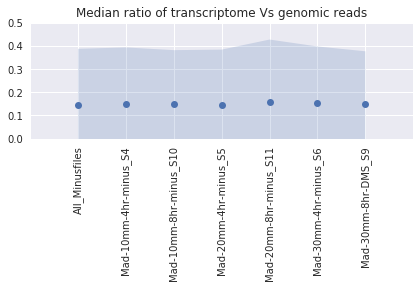

In [15]:
sns.set(font_scale=1)
ratios_readCounts_matrix = ratios_readCounts.values
ax = sns.tsplot(data=ratios_readCounts_matrix,estimator=np.median,interpolate=False, ci="sd")
labels_xaxis = list(ratios_readCounts_avg.index.values)
labels_xaxis.insert(0,"")
print labels_xaxis
ax.set_xticklabels(labels=labels_xaxis,rotation=90)
plt.ylim(0, 0.5)
plt.tight_layout()
plt.title("Median ratio of transcriptome Vs genomic reads")
plt.savefig("../results/MedianRatio_TranscriptomeVsGenomicReads_MinusDMS_"+str(numFeatures)+"MostHighlyExpressed"+removeNC_string+feature+"s"+featuresWithIntrons_string+".png")

['', 'All_Minusfiles', 'Mad-10mm-4hr-minus_S4', 'Mad-10mm-8hr-minus_S10', 'Mad-20mm-4hr-minus_S5', 'Mad-20mm-8hr-minus_S11', 'Mad-30mm-4hr-minus_S6', 'Mad-30mm-8hr-DMS_S9']


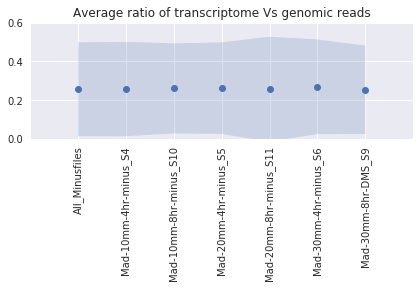

In [16]:
sns.set(font_scale=1)
ratios_readCounts_matrix = ratios_readCounts.values
ax = sns.tsplot(data=ratios_readCounts_matrix,estimator=np.mean,interpolate=False, ci="sd")
labels_xaxis = list(ratios_readCounts_avg.index.values)
labels_xaxis.insert(0,"")
print labels_xaxis
ax.set_xticklabels(labels=labels_xaxis,rotation=90)
plt.ylim(0, 0.6)
plt.tight_layout()
plt.title("Average ratio of transcriptome Vs genomic reads")
plt.savefig("../results/MeanRatio_TranscriptomeVsGenomicReads_MinusDMS_"+str(numFeatures)+"MostHighlyExpressed"+removeNC_string+feature+"s"+featuresWithIntrons_string+".png")

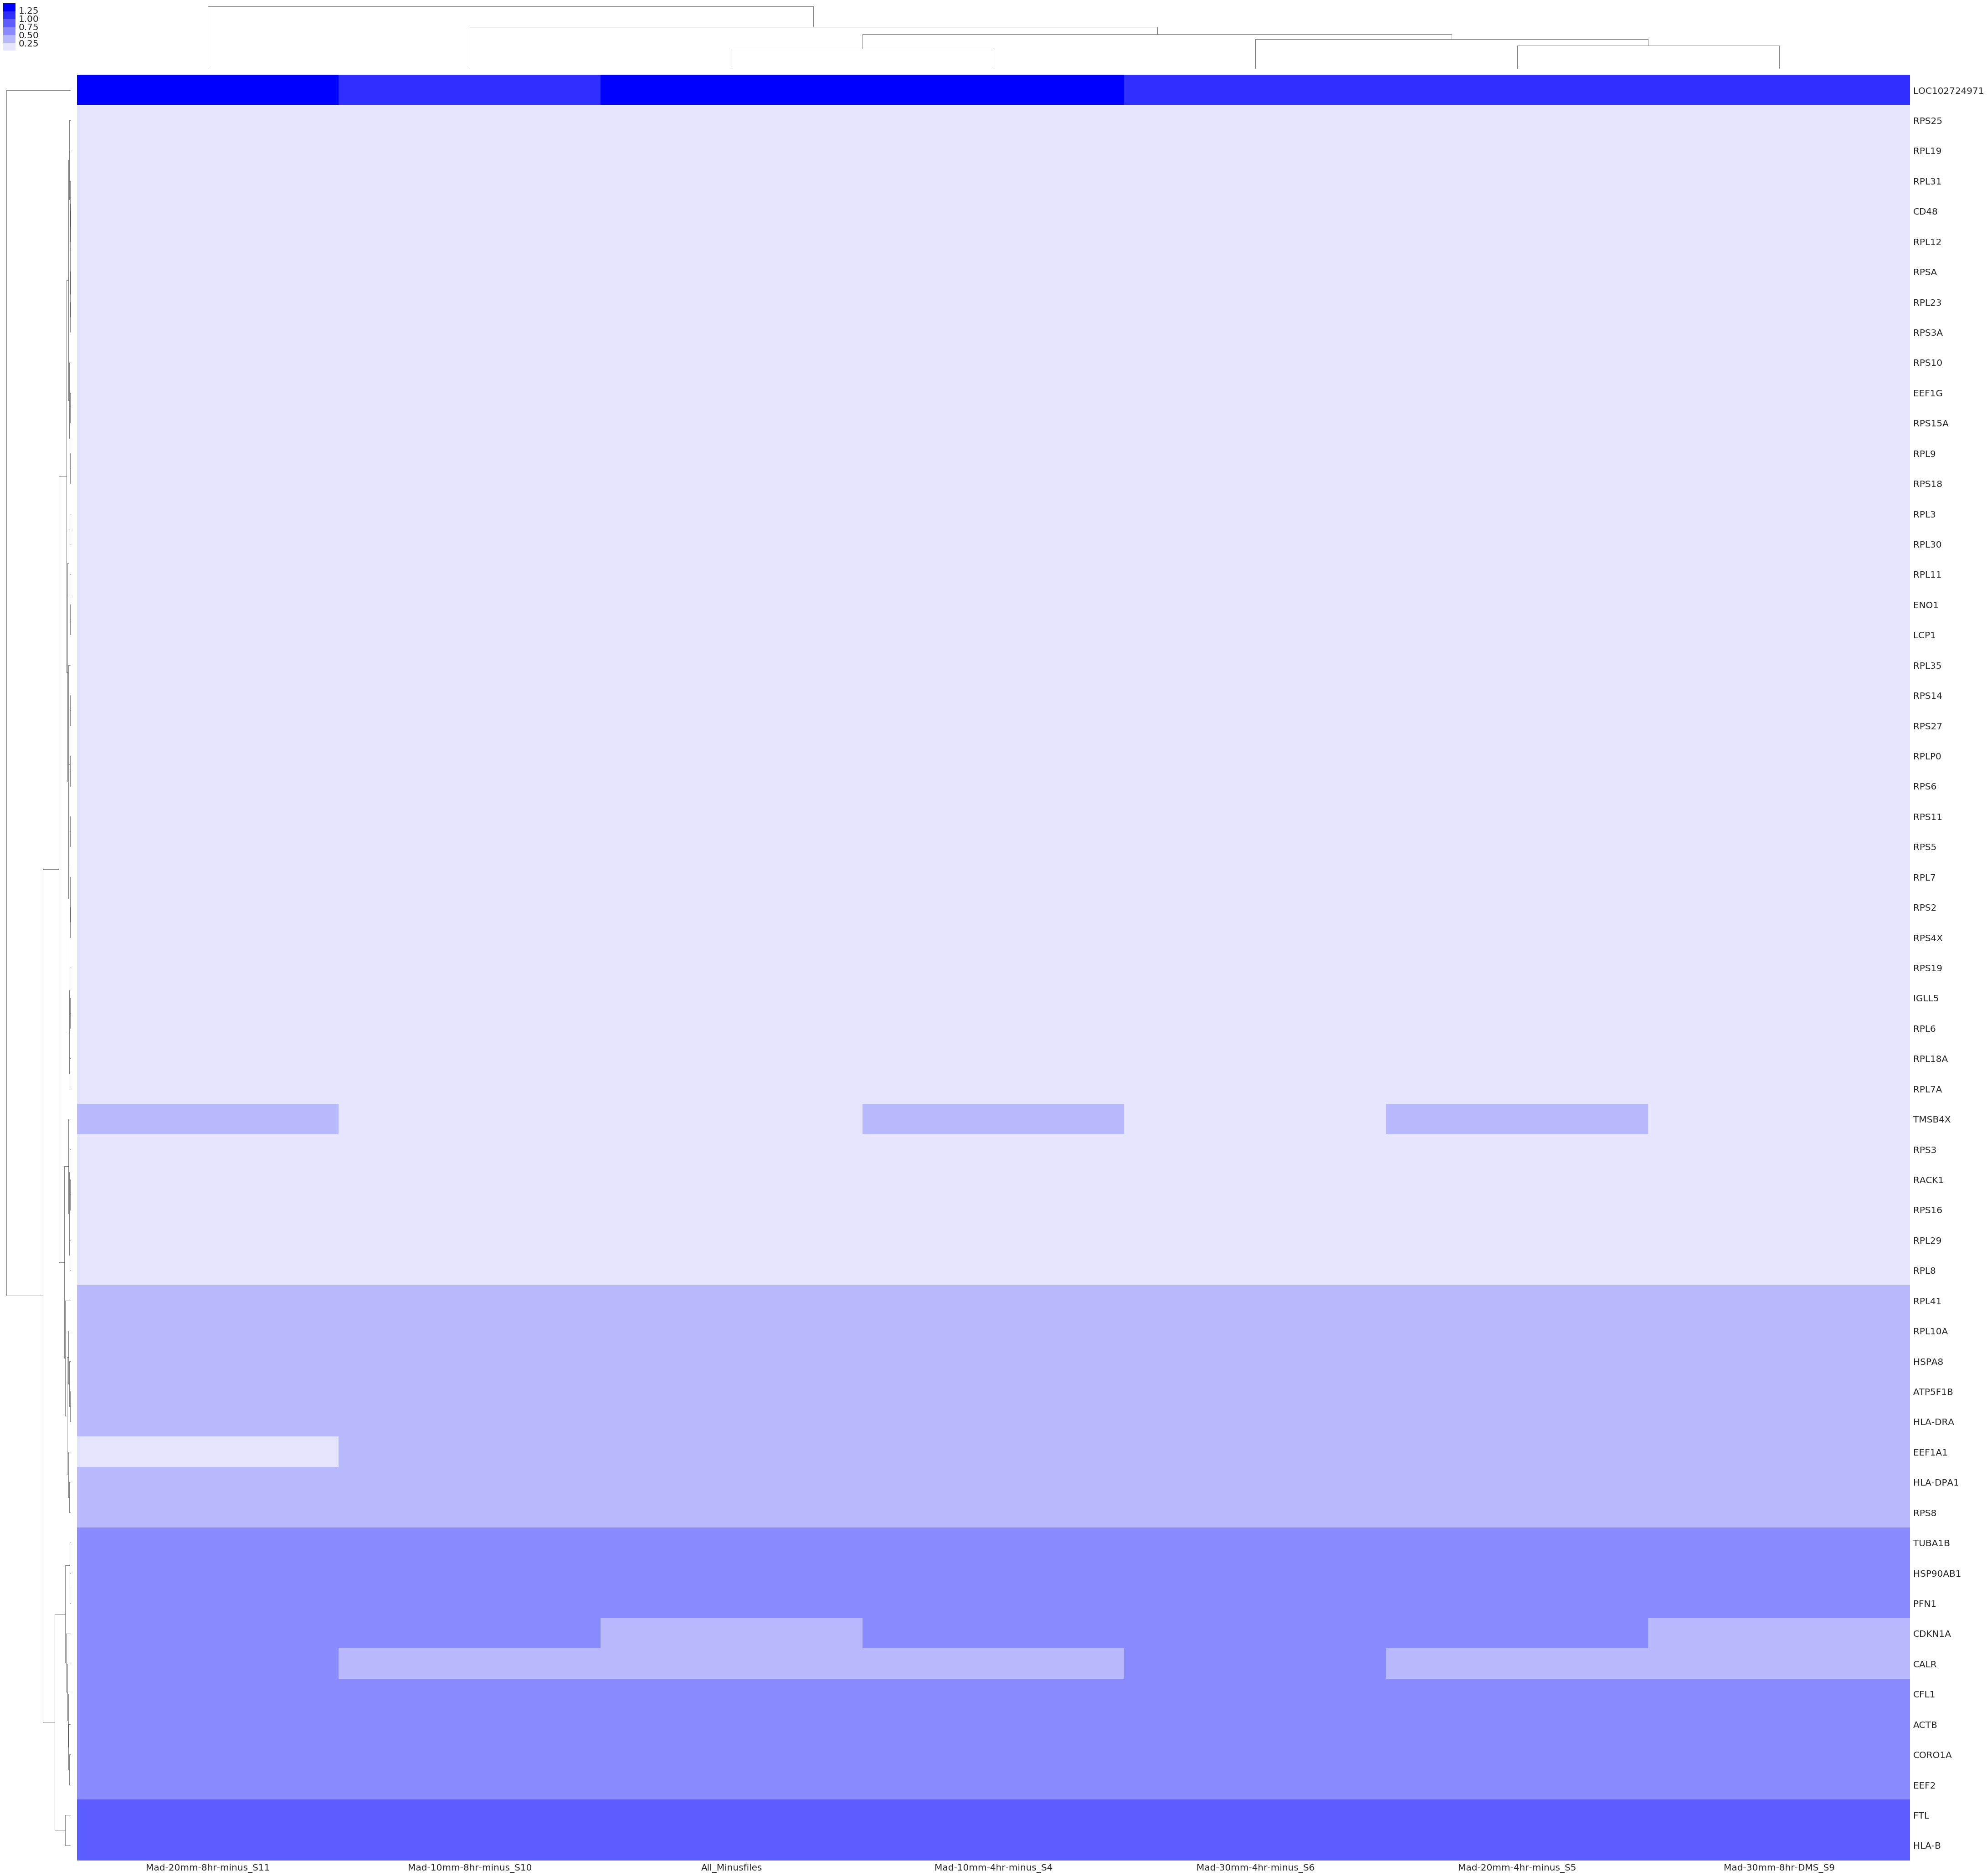

In [17]:
sns.set(font_scale=2)
ax = sns.clustermap(ratios_readCounts,cmap=sns.light_palette("blue"),annot=False, square=False, yticklabels=True, figsize=(75,75))
ax.savefig("../results/Ratio_TranscriptomeVsGenomicReads_MinusDMS_HeatMap_Clustered_"+str(numFeatures)+"MostHighlyExpressed"+removeNC_string+feature+"s"+featuresWithIntrons_string+".png")
reordered_indices = ax.dendrogram_row.reordered_ind

In [18]:
labels_indices_org = ratios_readCounts.index.values
labels_indices_reordered = labels_indices_org[reordered_indices]
# Reorder the feature counts indices 
ratios_readCounts= ratios_readCounts.reindex(labels_indices_reordered)

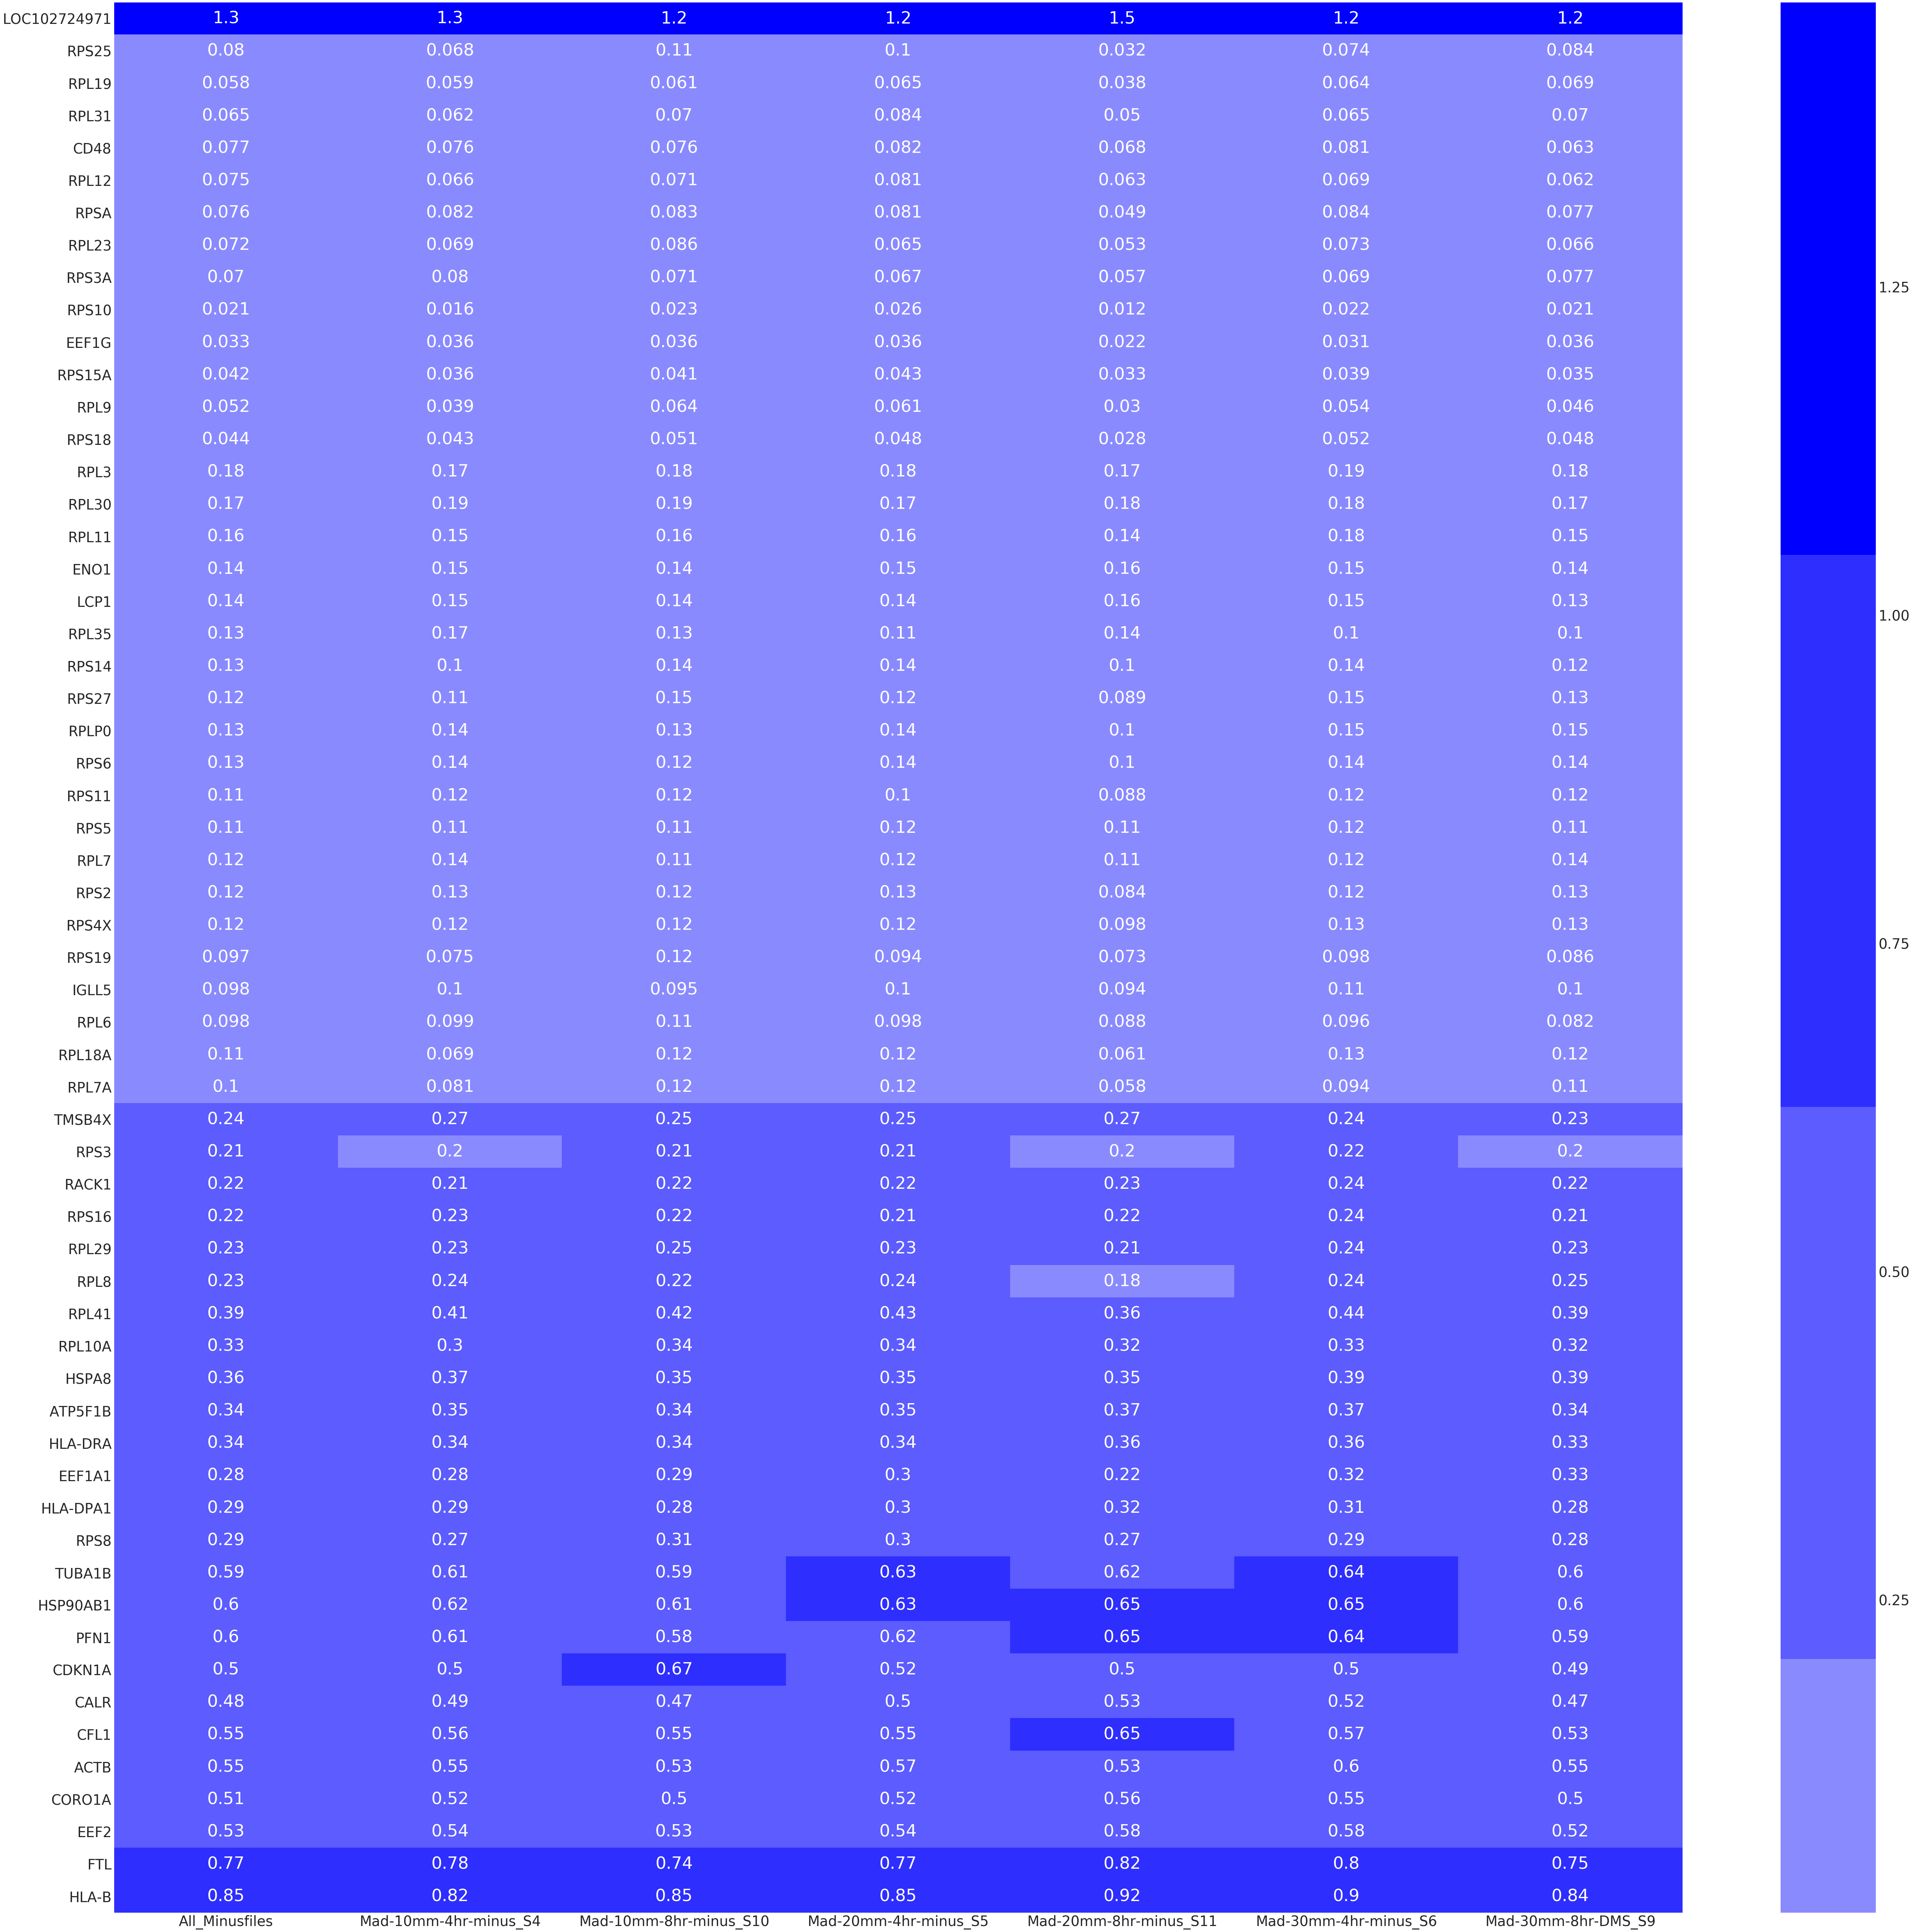

In [19]:
sns.set(font_scale=4)
fig, ax = plt.subplots(figsize=(100,100))
#sns.heatmap(ratios_readCounts_DMS,cmap="RdBu_r",vmax=1,vmin=0,yticklabels=True,center=0.5, ax=ax)
sns.heatmap(ratios_readCounts,cmap=sns.light_palette("blue"),yticklabels=True,annot=ratios_readCounts.values, ax=ax,center=0.2)
plt.savefig("../results/Ratio_TranscriptomeVsGenomicReads_MinusDMS_HeatMap_"+str(numFeatures)+"MostHighlyExpressed"+removeNC_string+feature+"s"+featuresWithIntrons_string+".png")

In [15]:
sorted_columns = sorted(list(ratios_readCounts.columns.values))
sorted_columns_NoControl = [i for i in sorted_columns if "All" not in i]

In [16]:
ratios_readCounts_JustMadrasin = ratios_readCounts[sorted_columns_NoControl]
print ratios_readCounts_JustMadrasin.shape
ratios_readCounts_JustMadrasin.head()

(59, 6)


,Mad-10mm-4hr-minus_S4,Mad-10mm-8hr-minus_S10,Mad-20mm-4hr-minus_S5,Mad-20mm-8hr-minus_S11,Mad-30mm-4hr-minus_S6,Mad-30mm-8hr-DMS_S9
ACTB,0.553171,0.531725,0.571713,0.529814,0.597551,0.552875
ATP5F1B,0.347437,0.341022,0.353043,0.371376,0.368836,0.336205
CALR,0.488961,0.474830,0.495011,0.526557,0.523077,0.472505
CD48,0.076203,0.076383,0.082105,0.068308,0.081317,0.062928
CDKN1A,0.496889,0.673024,0.522813,0.500495,0.499084,0.490600


In [17]:
# Let's get ratios of feature counts for Madrasin vs non Madrasin
ratiosToControl_readCounts = ratios_readCounts_JustMadrasin.divide(ratios_readCounts["All_Minusfiles"],axis=0)
print ratiosToControl_readCounts.shape
ratiosToControl_readCounts.head()

(59, 6)


,Mad-10mm-4hr-minus_S4,Mad-10mm-8hr-minus_S10,Mad-20mm-4hr-minus_S5,Mad-20mm-8hr-minus_S11,Mad-30mm-4hr-minus_S6,Mad-30mm-8hr-DMS_S9
ACTB,1.008025,0.968946,1.041814,0.965464,1.088899,1.007486
ATP5F1B,1.023565,1.004667,1.040079,1.094090,1.086606,0.990475
CALR,1.021235,0.991721,1.033872,1.099757,1.092489,0.986866
CD48,0.993364,0.995707,1.070301,0.890442,1.060026,0.820307
CDKN1A,1.001390,1.356358,1.053635,1.008659,1.005813,0.988717


In [23]:
# Lets the average for every time point and concentration
ratios_readCounts_avg = ratiosToControl_readCounts.apply(np.median,axis=0)
ratios_readCounts_avg

Mad-10mm-4hr-minus_S4     1.008025
Mad-10mm-8hr-minus_S10    1.017786
Mad-20mm-4hr-minus_S5     1.033872
Mad-20mm-8hr-minus_S11    0.935368
Mad-30mm-4hr-minus_S6     1.065082
Mad-30mm-8hr-DMS_S9       0.987386
dtype: float64

['', 'Mad-10mm-4hr-minus_S4', 'Mad-10mm-8hr-minus_S10', 'Mad-20mm-4hr-minus_S5', 'Mad-20mm-8hr-minus_S11', 'Mad-30mm-4hr-minus_S6', 'Mad-30mm-8hr-DMS_S9']


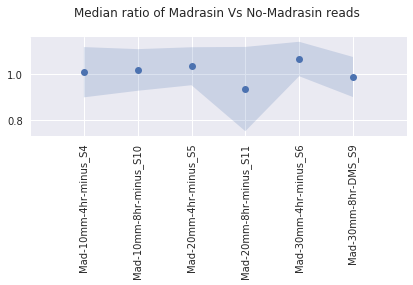

In [21]:
sns.set(font_scale=1)
ratios_readCounts_matrix = ratiosToControl_readCounts.values
ax = sns.tsplot(data=ratios_readCounts_matrix,estimator=np.median,interpolate=False, ci="sd")
labels_xaxis = list(ratios_readCounts_avg.index.values)
labels_xaxis.insert(0,"")
print labels_xaxis
ax.set_xticklabels(labels=labels_xaxis,rotation=90)

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.title("Median ratio of Madrasin Vs No-Madrasin reads \n")
plt.savefig("../results/MedianRatioUsingControls_TranscriptomeVsGenomicReads_MinusDMS_"+str(numFeatures)+"MostHighlyExpressed"+removeNC_string+feature+"s"+featuresWithIntrons_string+".png")

['', 'Mad-10mm-4hr-minus_S4', 'Mad-10mm-8hr-minus_S10', 'Mad-20mm-4hr-minus_S5', 'Mad-20mm-8hr-minus_S11', 'Mad-30mm-4hr-minus_S6', 'Mad-30mm-8hr-DMS_S9']


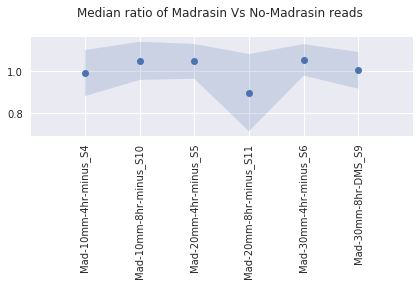

In [22]:
sns.set(font_scale=1)
ratios_readCounts_matrix = ratiosToControl_readCounts.values
ax = sns.tsplot(data=ratios_readCounts_matrix,estimator=np.mean,interpolate=False, ci="sd")
labels_xaxis = list(ratios_readCounts_avg.index.values)
labels_xaxis.insert(0,"")
print labels_xaxis
ax.set_xticklabels(labels=labels_xaxis,rotation=90)

plt.tight_layout()
plt.subplots_adjust(top=0.88)
plt.title("Median ratio of Madrasin Vs No-Madrasin reads \n")
plt.savefig("../results/MeanRatioUsingControls_TranscriptomeVsGenomicReads_MinusDMS_"+str(numFeatures)+"MostHighlyExpressed"+removeNC_string+feature+"s"+featuresWithIntrons_string+".png")

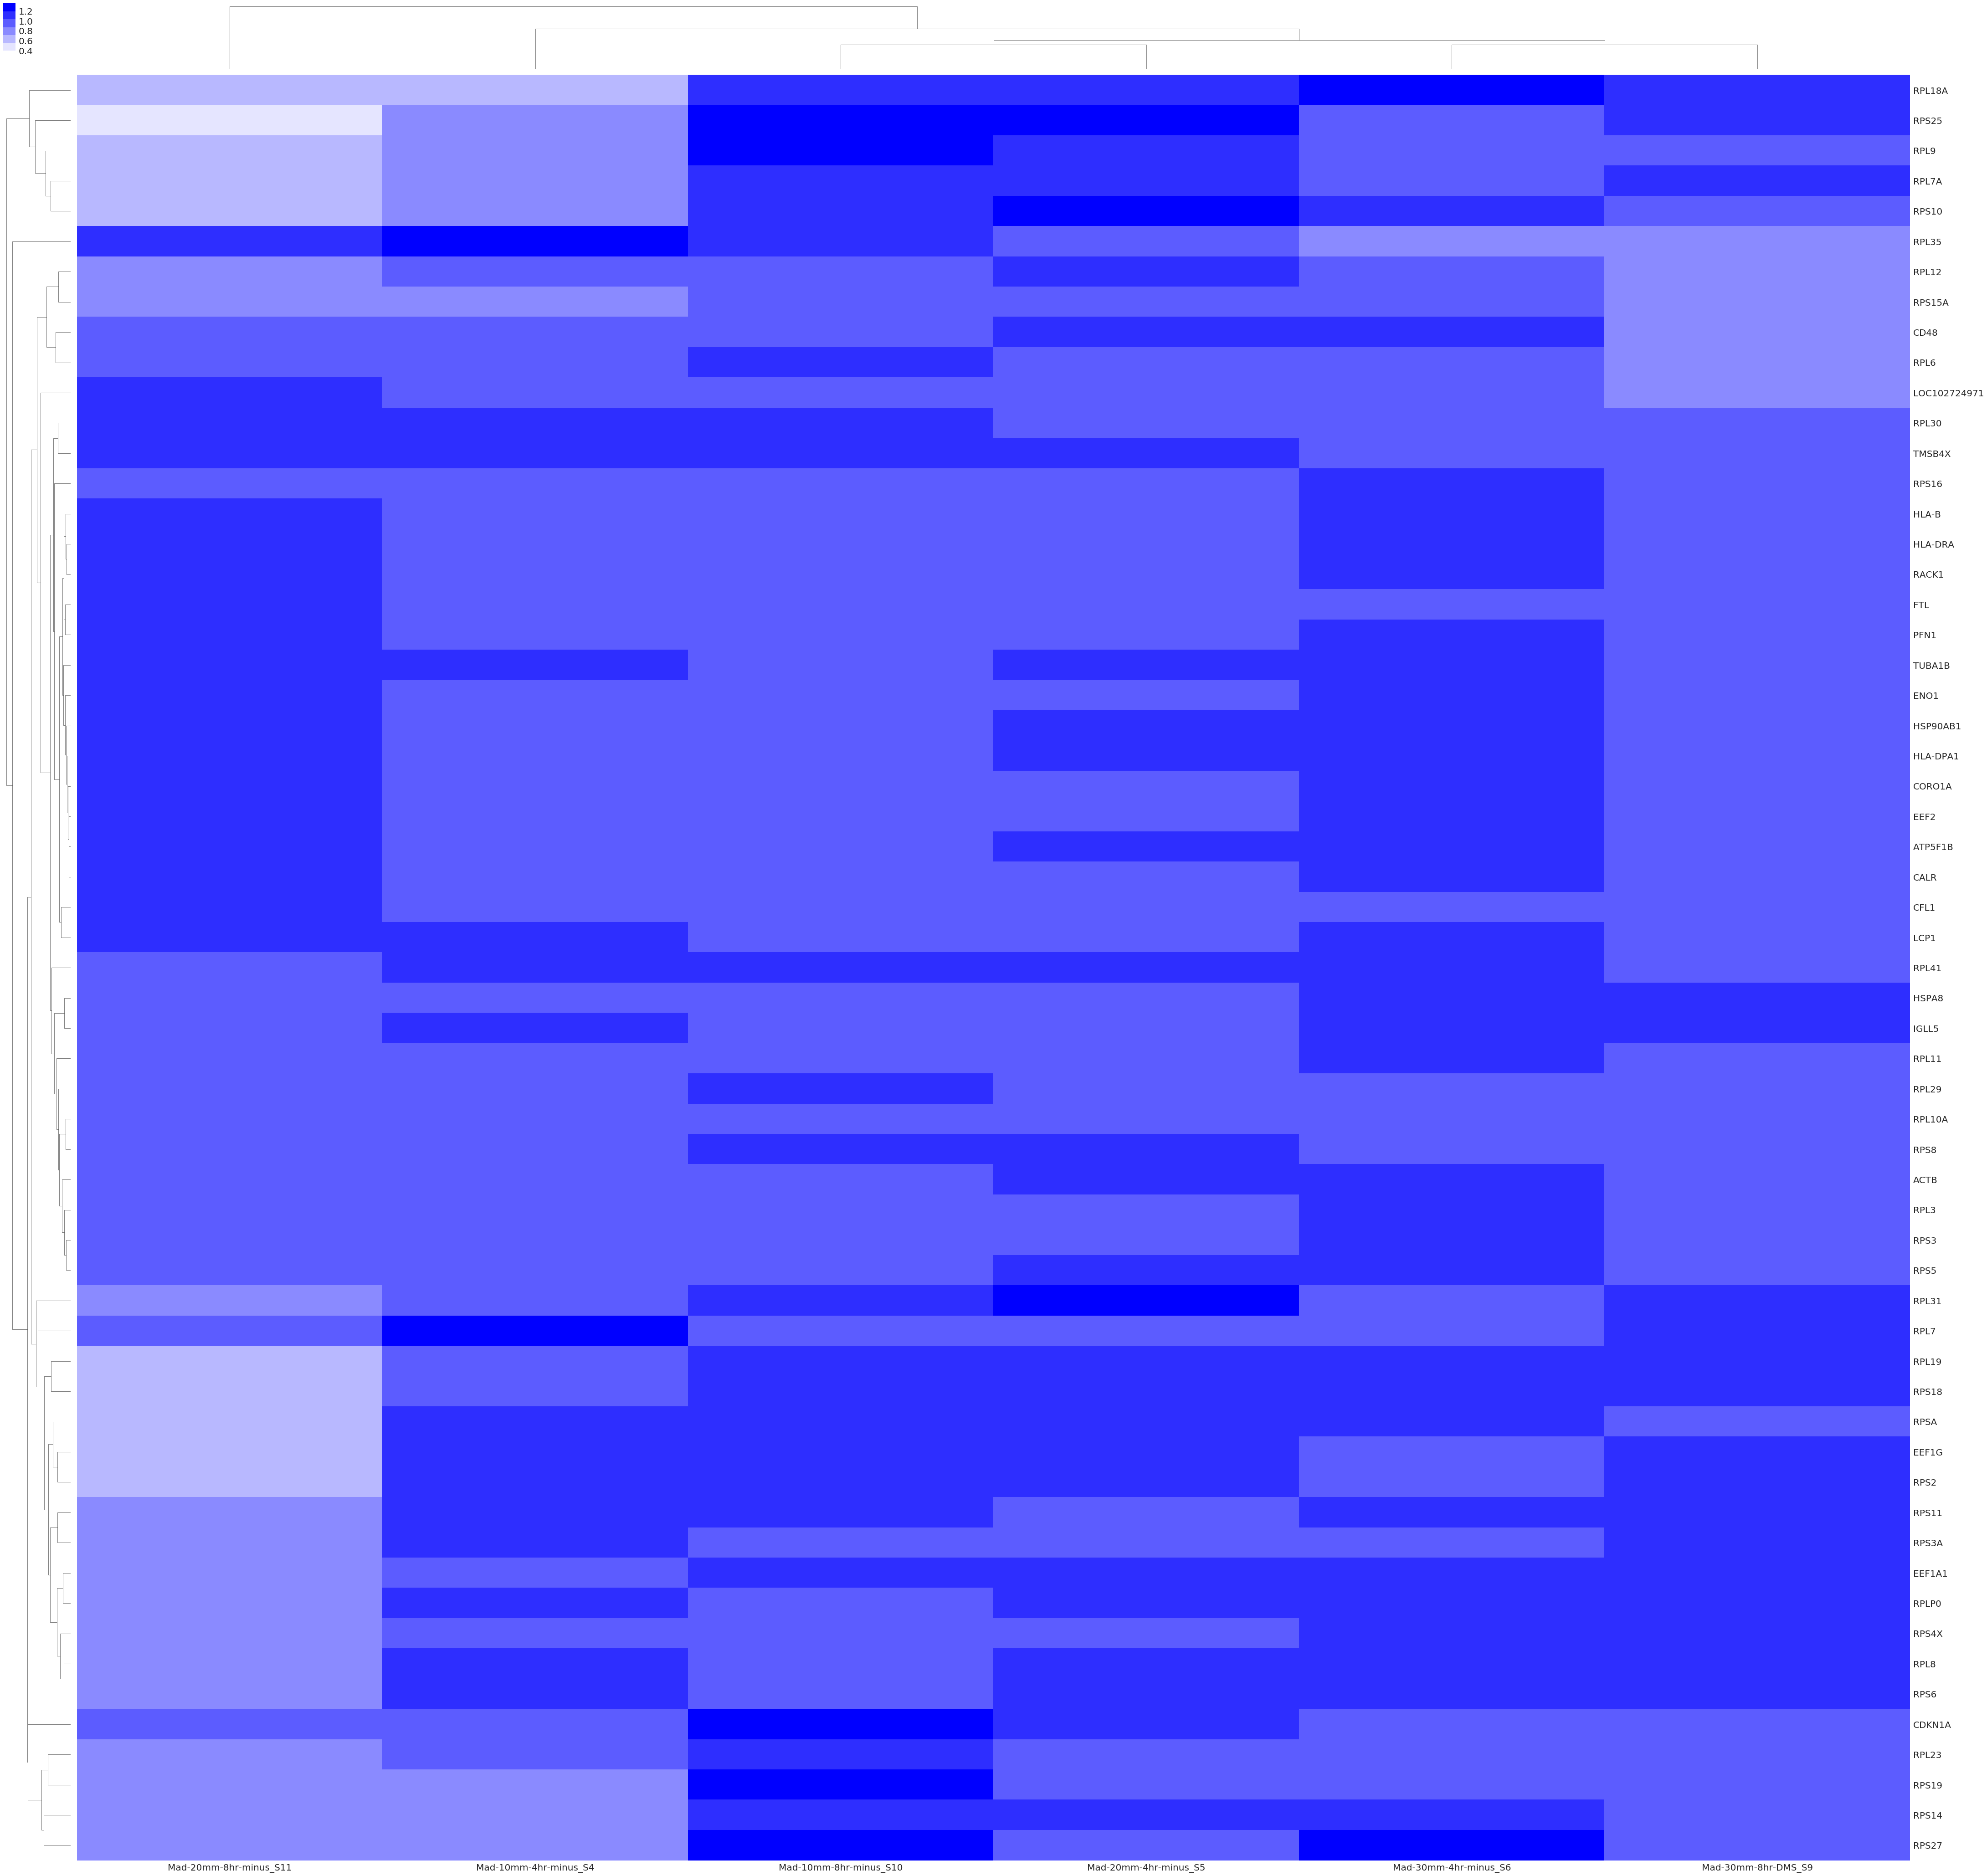

In [24]:
sns.set(font_scale=2)
ax = sns.clustermap(ratiosToControl_readCounts,cmap=sns.light_palette("blue"),annot=False, square=False, yticklabels=True, figsize=(75,75))
ax.savefig("../results/RatioUsingControls_TranscriptomeVsGenomicReads_MinusDMS_HeatMap_Clustered_"+str(numFeatures)+"MostHighlyExpressed"+removeNC_string+feature+"s"+featuresWithIntrons_string+".png")
reordered_indices = ax.dendrogram_row.reordered_ind

In [25]:
labels_indices_org = ratiosToControl_readCounts.index.values
labels_indices_reordered = labels_indices_org[reordered_indices]
# Reorder the feature counts indices 
ratiosToControl_readCounts= ratiosToControl_readCounts.reindex(labels_indices_reordered)

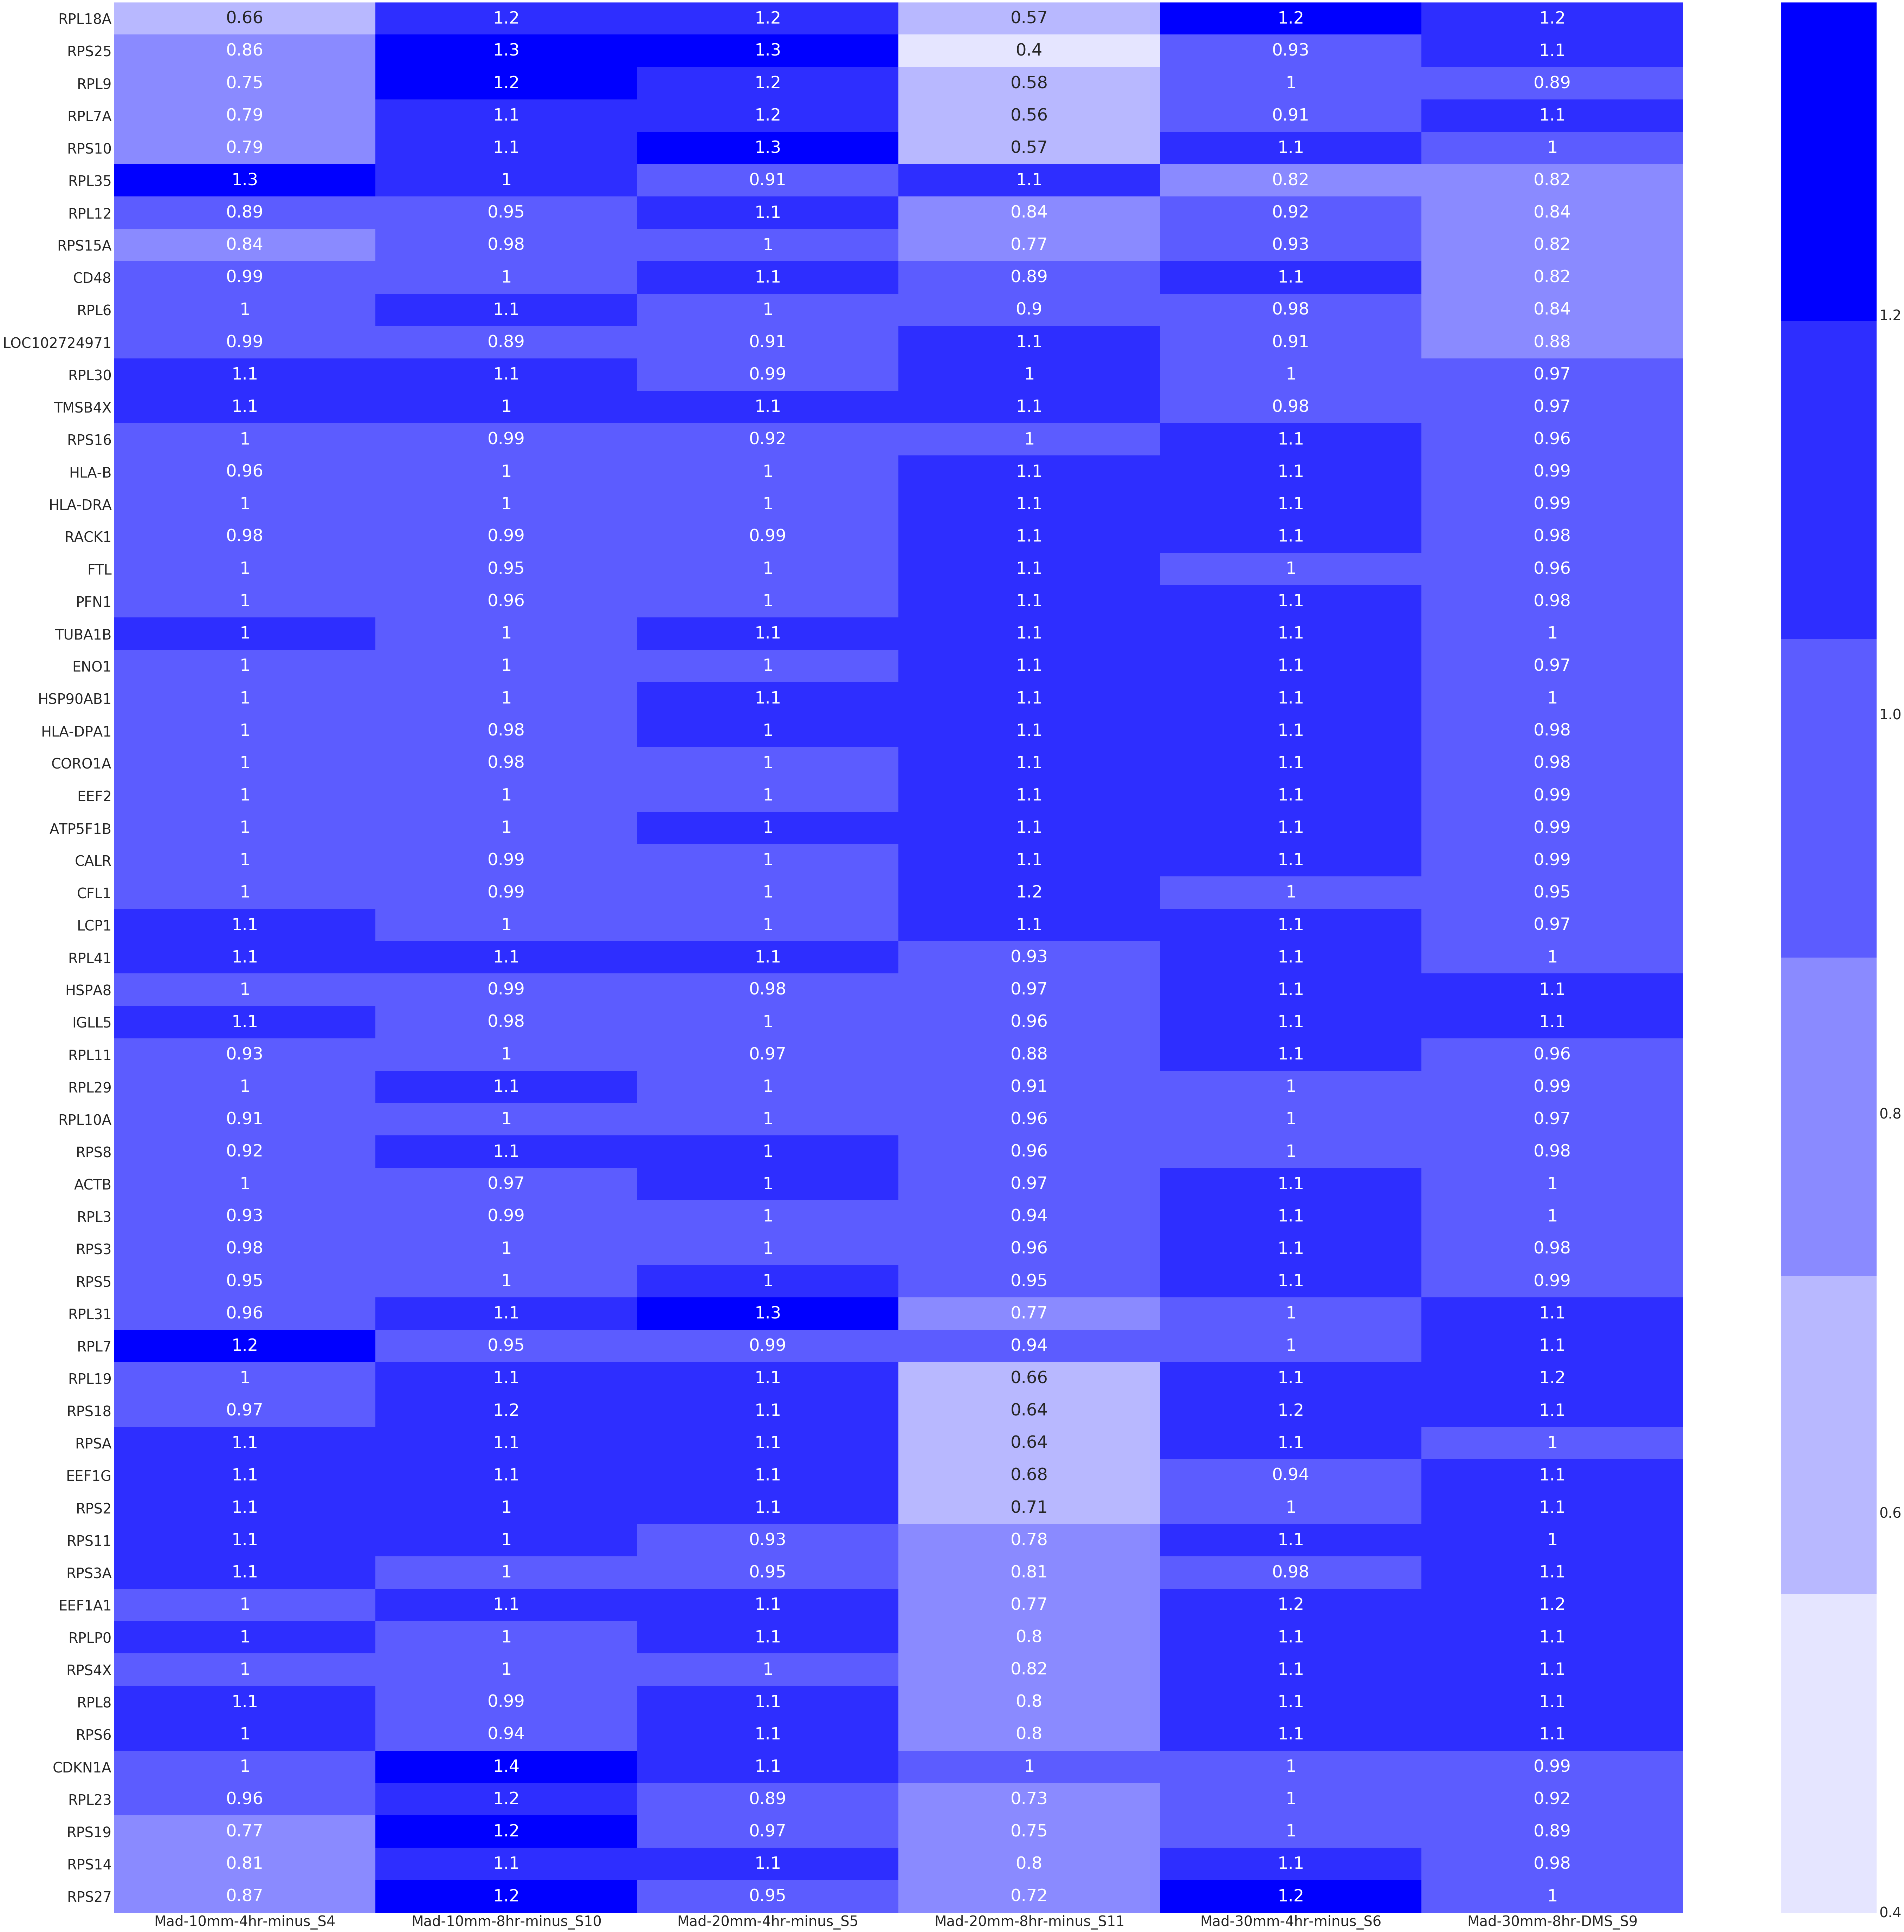

In [28]:
sns.set(font_scale=4)
fig, ax = plt.subplots(figsize=(100,100))
#sns.heatmap(ratios_readCounts_DMS,cmap="RdBu_r",vmax=1,vmin=0,yticklabels=True,center=0.5, ax=ax)
sns.heatmap(ratiosToControl_readCounts,cmap=sns.light_palette("blue"),yticklabels=True,annot=ratiosToControl_readCounts.values, ax=ax)#,center=0.2)
plt.savefig("../results/RatioUsingControls_TranscriptomeVsGenomicReads_MinusDMS_HeatMap_"+str(numFeatures)+"MostHighlyExpressed"+removeNC_string+feature+"s"+featuresWithIntrons_string+".png")